In [1]:
# General
import numpy as np
import pandas as pd
import nltk
import random
import os
from os import path
from PIL import Image

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

In [2]:
# Set Plot Theme
sns.set_palette([
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
])
# Alternate # plt.style.use('fivethirtyeight')

# Pre-Processing
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer

In [4]:
# Modeling
import statsmodels.api as sm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.util import ngrams
from collections import Counter
from gensim.models import word2vec

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Read and Peak at Data
df = pd.read_csv("Dataset/Womens Clothing E-Commerce Reviews.csv")
df.drop(df.columns[0],inplace=True, axis=1)

# Delete missing observations for following variables
for x in ["Division Name","Department Name","Class Name","Review Text"]:
    df = df[df[x].notnull()]

# Extracting Missing Count and Unique Count by Column
unique_count = []
for x in df.columns:
    unique_count.append([x,len(df[x].unique()),df[x].isnull().sum()])

# Missing Values
print("Missing Values: {}".format(df.isnull().sum().sum()))

# Data Dimensions
print("Dataframe Dimension: {} Rows, {} Columns".format(*df.shape))

# Create New Variables: 
# Word Length
df["Word Count"] = df['Review Text'].str.split().apply(len)
# Character Length
df["Character Count"] = df['Review Text'].apply(len)
# Boolean for Positive and Negative Reviews
df["Label"] = 0
df.loc[df.Rating >= 3,["Label"]] = 1

Missing Values: 2966
Dataframe Dimension: 22628 Rows, 10 Columns


In [8]:
df.sample(5)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Word Count,Character Count,Label
20848,1078,21,Love,I bought the one with blue and white top and b...,5,1,0,General,Dresses,Dresses,59,287,1
5366,877,25,Love love,Love this shirt and the print. i would wear it...,5,1,0,General,Tops,Knits,70,357,1
20717,833,32,Great top - beautiful details,Highly recommend this top. received lots of co...,5,1,1,General,Tops,Blouses,20,114,1
5395,985,61,Soft and flattering,"What a great little find. it is so soft, and t...",5,1,0,General Petite,Jackets,Jackets,101,500,1
20390,818,60,"Exactly as pictured, adorable spring top",Love this top. it is exactly as pictured onlin...,5,1,3,General,Tops,Blouses,96,500,1


In [9]:
print("Dataframe Dimension: {} Rows, {} Columns".format(*df.shape))
pd.DataFrame(unique_count, columns=["Column","Unique","Missing"]).set_index("Column").T

Dataframe Dimension: 22628 Rows, 13 Columns


Column,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
Unique,1172,77,13984,22621,5,2,82,3,6,20
Missing,0,0,2966,0,0,0,0,0,0,0


In [10]:
df.describe().T.drop("count",axis=1)

,mean,std,min,25%,50%,75%,max
Clothing ID,919.695908,201.683804,1.0,861.0,936.0,1078.0,1205.0
Age,43.282880,12.328176,18.0,34.0,41.0,52.0,99.0
Rating,4.183092,1.115911,1.0,4.0,5.0,5.0,5.0
Recommended IND,0.818764,0.385222,0.0,1.0,1.0,1.0,1.0
Positive Feedback Count,2.631784,5.787520,0.0,0.0,1.0,3.0,122.0
Word Count,60.211950,28.533053,2.0,36.0,59.0,88.0,115.0
Character Count,308.761534,143.934126,9.0,186.0,302.0,459.0,508.0
Label,0.895263,0.306222,0.0,1.0,1.0,1.0,1.0


In [11]:
df[["Title", "Division Name","Department Name","Class Name"]].describe(include=["O"]).T.drop("count",axis=1)

,unique,top,freq
Title,13983,Love it!,136
Division Name,3,General,13365
Department Name,6,Tops,10048
Class Name,20,Dresses,6145


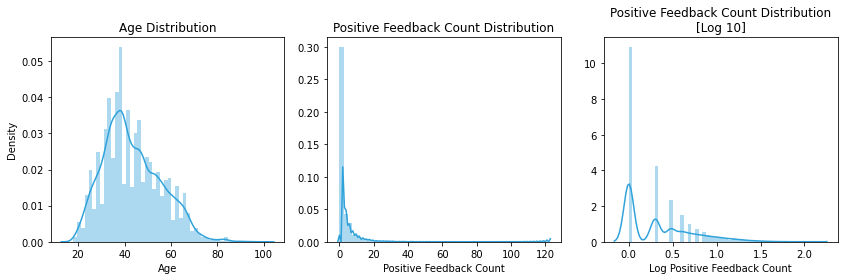

In [12]:
# Continous Distributions
f, ax = plt.subplots(1,3,figsize=(12,4), sharey=False)
sns.distplot(df.Age, ax=ax[0])
ax[0].set_title("Age Distribution")
ax[0].set_ylabel("Density")
sns.distplot(df["Positive Feedback Count"], ax=ax[1])
ax[1].set_title("Positive Feedback Count Distribution")
sns.distplot(np.log10((df["Positive Feedback Count"][df["Positive Feedback Count"].notnull()]+1)), ax=ax[2])
ax[2].set_title("Positive Feedback Count Distribution\n[Log 10]")
ax[2].set_xlabel("Log Positive Feedback Count")
plt.tight_layout()
plt.show()

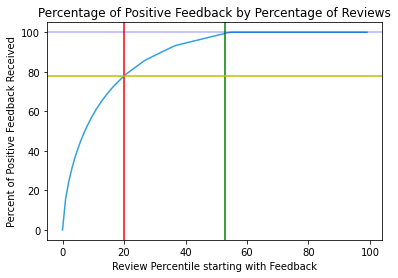

78.0% of Positive Feedback belongs to the top 20% of Reviews

Gini Coefficient: 0.76


In [13]:
# Percentage Accumulation from "Most Wealthy"
def percentage_accumulation(series, percentage):
    return (series.sort_values(ascending=False)
            [:round(series.shape[0]*(percentage/100))]
     .sum()/series
     .sum()*100)

# Gini Coefficient- Inequality Score
# Source: https://planspace.org/2013/06/21/how-to-calculate-gini-coefficient-from-raw-data-in-python/
def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area

# Cumulative Percentage of Positive Feedback assigned Percent of Reviewers (from most wealthy)
inequality = []
for x in list(range(100)):
    inequality.append(percentage_accumulation(df["Positive Feedback Count"], x))

# Generic Matplotlib Plot
plt.plot(inequality)
plt.title("Percentage of Positive Feedback by Percentage of Reviews")
plt.xlabel("Review Percentile starting with Feedback")
plt.ylabel("Percent of Positive Feedback Received")
plt.axvline(x=20, c = "r")
plt.axvline(x=53, c = "g")
plt.axhline(y=78, c = "y")
plt.axhline(y=100, c = "b", alpha=.3)
plt.show()

# 80-20 Rule Confirmation
print("{}% of Positive Feedback belongs to the top 20% of Reviews".format(
    round(percentage_accumulation(df["Positive Feedback Count"], 20))))

# Gini
print("\nGini Coefficient: {}".format(round(gini(df["Positive Feedback Count"]),2)))